# Практика по PyTorch

In [1]:
import warnings
warnings.filterwarnings('ignore')

from math import sin, exp
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Зафиксируем seed для воспроизводимости

def seed_everything(seed):
    torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(seed) # фиксируем генератор случайных чисел для GPU

In [3]:
seed_everything(42)

Сгенерируем матрицу 20000*2 в диапазоне [-10;10].

In [40]:
max_val = 10
min_val = -10
shape = (20000, 2)
rand_tensor = (max_val - min_val) * torch.rand(shape) + min_val
rand_tensor[:5]

tensor([[ 6.3694, -5.8791],
        [ 8.4526,  3.7445],
        [ 3.0376,  1.2842],
        [ 0.4647,  3.2832],
        [-4.5918,  6.8840]])

In [41]:
rand_tensor.shape

torch.Size([20000, 2])

Аппроксимируемая функция:  
$$sin(x + 2y) * exp(-(2x + y)^2)$$

In [42]:
def calc_target(x, y):
    target = sin(x + 2 * y) * exp(-(2 * x + y) ** 2)
    return target

calc_target(7.6454, 8.3001)

-1.5534601187573117e-242

Рассчитаем значения целевой переменной по функции.

In [43]:
target_tensor = torch.FloatTensor([calc_target(s[0], s[1]) for s in rand_tensor])
target_tensor = target_tensor.unsqueeze(1)
target_tensor[:5]

tensor([[ 2.8566e-21],
        [-0.0000e+00],
        [-1.8870e-24],
        [ 1.3356e-08],
        [ 1.2424e-03]])

In [44]:
target_tensor.shape

torch.Size([20000, 1])

Так как данные сгенерированы случайно, то проведем небольшой EDA, чтобы понимать, чего стоит ожидать.  

In [45]:
print(torch.kthvalue(target_tensor.squeeze(1), int(0.95 * target_tensor.squeeze(1).size(0)))[0])
print(torch.kthvalue(target_tensor.squeeze(1), int(0.05 * target_tensor.squeeze(1).size(0)))[0])

tensor(0.0087)
tensor(-0.0086)


Видимо, большая часть данных сконцентрирована около нуля.  

Посмотрим на кривую целевой переменной.  

Text(0.5, 1.0, 'Target variable')

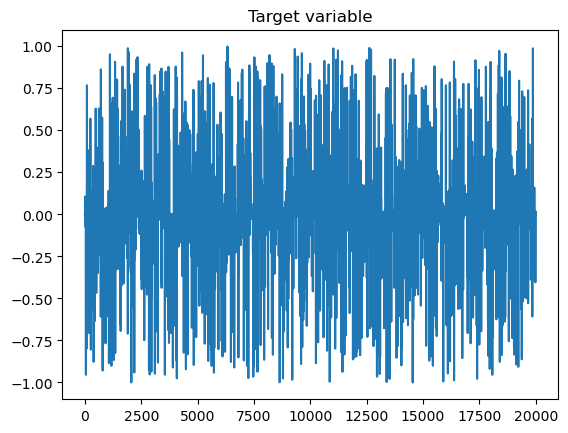

In [46]:
sns.lineplot(data=target_tensor, legend=False)
plt.title('Target variable')

Ничего не понятно, лучше посмотрим на скользящее среднее.  

In [49]:
def rolling_mean(x, window_size):
    weights = torch.ones(window_size) / window_size
    weights = weights.unsqueeze(0).unsqueeze(0).double()
    return torch.nn.functional.conv1d(x.unsqueeze(0).double(), weights).squeeze(0)

Text(0.5, 1.0, 'Rolling mean of target variable')

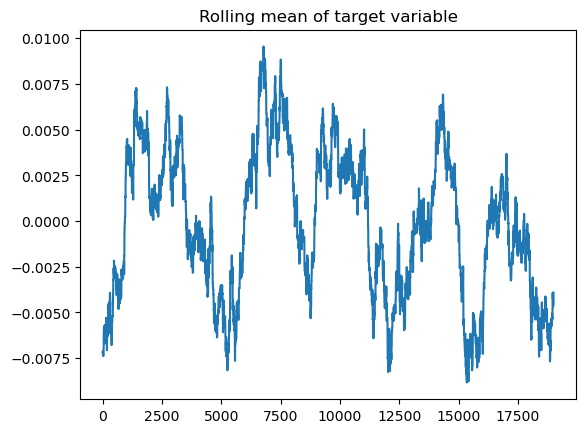

In [50]:
window_size = 1000
rolling_mean_tensor = rolling_mean(target_tensor.squeeze(1), window_size)
sns.lineplot(data=rolling_mean_tensor, legend=False)
plt.title('Rolling mean of target variable')

Подготовим данные для обучения.  

In [51]:
data = torch.cat((rand_tensor, target_tensor), 1).to(torch.float32)
data

tensor([[ 6.3694e+00, -5.8791e+00,  2.8566e-21],
        [ 8.4526e+00,  3.7445e+00, -0.0000e+00],
        [ 3.0376e+00,  1.2842e+00, -1.8870e-24],
        ...,
        [-4.2377e+00,  2.7009e+00,  3.0267e-15],
        [-4.6903e+00, -1.6554e+00, -0.0000e+00],
        [-5.7537e+00,  4.1318e-01,  0.0000e+00]])

In [52]:
data.shape

torch.Size([20000, 3])

In [53]:
num_features = 2

In [54]:
X_train, X_remain, y_train, y_remain = train_test_split(
    data[:, :num_features],
    data[:, num_features],
    test_size=0.3,
    shuffle=True
)

X_test, X_val, y_test, y_val = train_test_split(
    X_remain,
    y_remain,
    test_size=0.5,
    shuffle=True
)

train_dataset = np.zeros((X_train.shape[0], num_features + 1))
train_dataset[:, :num_features] = X_train
train_dataset[:, num_features] = y_train

test_dataset = np.zeros((X_test.shape[0], num_features + 1))
test_dataset[:, :num_features] = X_test
test_dataset[:, num_features] = y_test

val_dataset = np.zeros((X_val.shape[0], num_features + 1))
val_dataset[:, :num_features] = X_val
val_dataset[:, num_features] = y_val

train_dataset = torch.from_numpy(train_dataset)
test_dataset = torch.from_numpy(test_dataset)
val_dataset = torch.from_numpy(val_dataset)

In [55]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

Посмотрим, что в батчах все ок с размерностями.

In [56]:
for batch in train_loader:
    features = batch[:, :num_features]
    labels = batch[:, num_features]
    print(features.shape)
    print(labels.shape)
    break

torch.Size([16, 2])
torch.Size([16])


Определим архитектуру сети.  

In [57]:
class RegressionNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RegressionNet, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = torch.nn.Linear(hidden_dim, output_dim)
        self.tanh = torch.nn.Tanh()
        
    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.fc4(x)
        return x

Обучим сеть.  

In [58]:
def train_net(net_params, train_loader):
    net = RegressionNet(
        net_params['input_dim'],
        net_params['hidden_dim'],
        net_params['output_dim']
    )

    criterion = torch.nn.SmoothL1Loss()
    optimizer = torch.optim.SGD(net.parameters(), lr=net_params['lr'])
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Training on: {device}')
    net.train(True)
    
    history = []
    epochs = net_params['epochs']
    
    for i in tqdm(range(epochs)):
        epoch_loss = []
        # Итерируемся по батчам
        for batch in train_loader:
            optimizer.zero_grad()
            # Делаем предсказания
            x = batch[:, :num_features].float().to(device)
            y = batch[:, num_features].float().to(device)
            pred_y = net(x)
    
            # Считаем ошибку
            loss = criterion(pred_y, y)
            epoch_loss.append(loss.item())
    
            # Вычисляем градиент
            loss.backward()
            
            # Корректируем веса
            optimizer.step()
        if i % 10 == 0:
            history.append(np.array(epoch_loss).mean())
            
    net.train(False)
    return net, history

In [59]:
net_params = {
    'input_dim': 2,
    'hidden_dim': 64,
    'output_dim': 1,
    'lr': 1.0e-3,
    'epochs': 100
}

regression_net, history = train_net(net_params, train_loader)

Training on: cpu


100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


Посмотрим, как падала ошибка.  

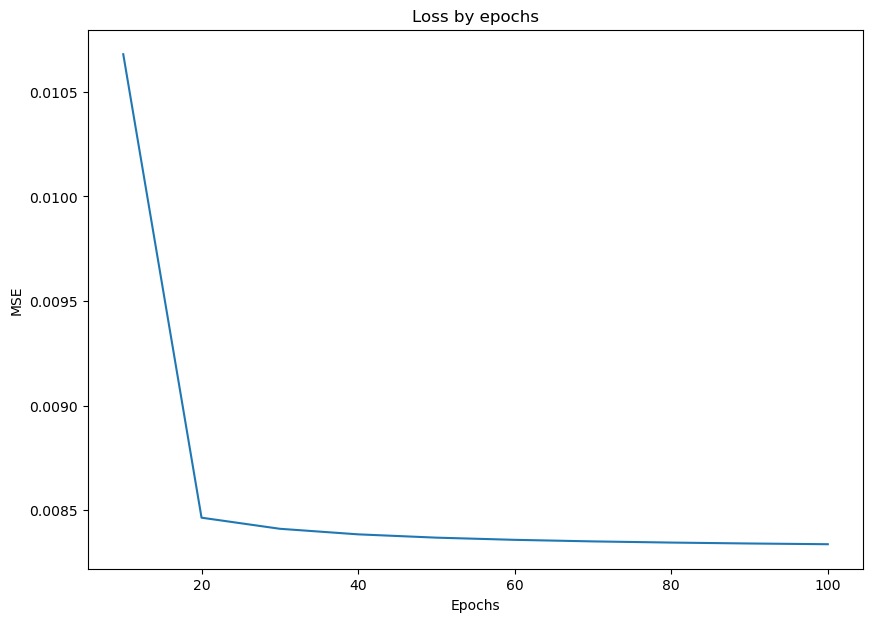

In [60]:
plt.figure(figsize=(10, 7))
sns.lineplot(y=history, x=[i * 10 for i in range(1, len(history) + 1)])

plt.title('Loss by epochs')
plt.ylabel('MSE')
plt.xlabel('Epochs')

plt.show()

Сохраним веса, чтобы не обучаться каждый раз.  

In [61]:
torch.save(regression_net, './regression_net.pth')

In [62]:
regression_net = torch.load('./regression_net.pth')

Посчитаем ошибку на тестовых данных.  

In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
history_test = []

with torch.no_grad():
    for batch in test_loader:
        x = batch[:, :num_features].float().to(device)
        y_true = batch[:, num_features].float()

        y_pred = regression_net(x)

        batch_mse = torch.nn.functional.l1_loss(y_pred, y_true, reduction='mean')

        history_test.append(batch_mse.item())

train_mse = history[-1]
test_mse = sum(history_test) / len(history_test)
print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')

Train MSE: 0.008337438911264015
Test MSE: 0.03150729957888735


Попробуем сравнить предсказания модели с реальными значениями на валидационной выборке.  

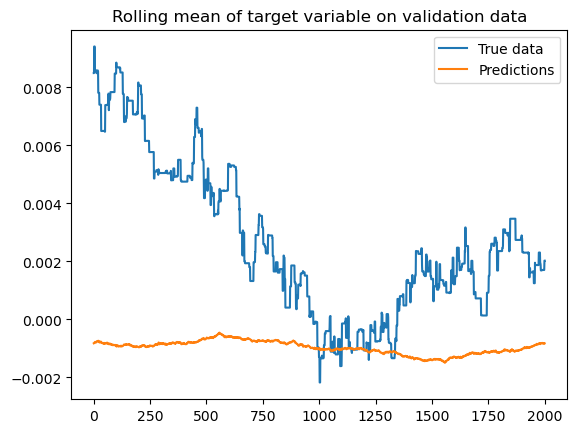

In [64]:
val_tensor = val_dataset[:, num_features]
pred_val_tensor = regression_net(val_dataset[:, :num_features].float())

val_rolling_mean = rolling_mean(val_tensor, window_size)
pred_val_rolling_mean = rolling_mean(torch.tensor(pred_val_tensor.squeeze(1), dtype=torch.float64), window_size)
    
sns.lineplot(data=val_rolling_mean, label='True data')
sns.lineplot(data=pred_val_rolling_mean, label='Predictions')
plt.title('Rolling mean of target variable on validation data')
plt.show()

Получилось сильно не очень. Думаю, это связано с тем, что 90% данных были около 0, а остальные 10% - жуткие аномалии.    